<a href="https://colab.research.google.com/github/egorssed/Lensed_Source_modelling_research/blob/main/VAE_training_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
Folder='/content/drive/My Drive/Lensed Source modelling research/'

import sys
import os
sys.path.append(Folder+'/Modules')
import Image_Stats
import Visual_analysis

image_size=64
batch_size = 32
latent_dim = 64
start_lr = 1e-6

x = np.linspace(0, 64, 64)
y = np.linspace(0, 64, 64)
X, Y = np.meshgrid(x, y)
xdata = np.vstack((X.ravel(), Y.ravel()))

Mounted at /content/drive


### Prepare the data

In [2]:
from sklearn.model_selection import train_test_split
import keras.backend as K
import tensorflow as tf

#We normalize the data to [0,1]
#Initial minI and maxI are stored in the Dataset_labels
#All the negative values set to 0 during preprocessing
def normalize_image(images):
    #Normalize image to [0,1]
    for i in range(len(images)):
        images[i][images[i]<0]=0
        images[i]=images[i]/images[i].max()
    return images

def get_matrix_shape(array,matrix):
  if array.shape[0]==matrix.shape[0]:
    result=K.reshape(tf.repeat(array,tf.size(matrix[0])),(matrix.shape))
    return tf.cast(result,matrix.dtype)
  else:
    return False

#Read the images and the features from the google drive
galaxy_images=np.load(Folder+'Data/MAD_new_Dataset/Images_MAD_Filtered.npy')
df=pd.read_csv(Folder+'Data/MAD_new_Dataset/Labels_MAD_Filtered.csv',index_col=0)

def change_noise(series):
    if (series.Background_x_size<20) or (series.Background_y_size<20):
        series.Noise_sigma=series.COSMOS_noise

_=df.apply(change_noise,axis=1)

#Bring images to a proper tensorial form
Size_of_dataset=len(galaxy_images[:-(len(galaxy_images)%batch_size)])
Number_of_batches=Size_of_dataset//batch_size
df=df.iloc[:Size_of_dataset]
galaxy_images=galaxy_images[:Size_of_dataset]
index=np.linspace(0,len(df)-1,len(df),dtype='int')

#Bring images to a proper tensorial form
gal_dataset_images=np.reshape(normalize_image(copy.deepcopy(galaxy_images)), 
                              (len(galaxy_images), galaxy_images.shape[1], galaxy_images.shape[2], 1)).astype('float32')
#Separate the features we are eager to predict in the latent space
Features=['max_I','Noise_sigma']

#Extract test dataset
x_train,x_test,y_train,y_test= train_test_split(gal_dataset_images, df[Features].astype('float32'), test_size=round(0.05*Number_of_batches)*batch_size,random_state=42)
#Extract train and validation datasets
x_train, x_val , y_train, y_val= train_test_split(x_train, y_train, test_size=round(0.05*Number_of_batches)*batch_size,random_state=42)
#All the sets have number of galaxies which is a multiple of the batch size (32)
#The random_state is fixed so the split is reproducible yet random

Take a look at the scheme of the loss. These are the very tagret_x_labeled
Representing Sersic parameters as they are in the latent space will ruin numerical stability (HLR~10)
So I bring the Labels distribution to mean=0, std=1 and then models['features_predictor] will bring everything back

In [3]:
Features_number=len(Features)
Features_means=df[Features].mean(axis=0)
Features_stds=df[Features].std(axis=0)

def make_labeled_images(x,labels):
  res=np.zeros((len(x),x.shape[1]+1,x.shape[2],1))
  res[:,:-1,:,:]=x
  res[:,-1,:Features_number,0]=labels
  return res.astype('float32')

x_train_labeled=make_labeled_images(x_train,y_train)
x_test_labeled=make_labeled_images(x_test,y_test)
x_val_labeled=make_labeled_images(x_val,y_val)
galaxies_labeled=make_labeled_images(gal_dataset_images,df[Features])

### VAE 

#### libraries

In [17]:
import tensorflow as tf
from keras.layers import Input, Dense, BatchNormalization,Flatten,Reshape,Lambda,Conv2D,Conv2DTranspose,LeakyReLU
from keras.models import Model
from keras.optimizers import Adam
from keras import initializers
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops,smart_cond
import keras.backend as K

#### encoder

In [18]:
def encoder_function(input_img):
    #He initialization for Relu activated layers
    Heinitializer = initializers.HeNormal()

    x = Conv2D(filters=64, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(input_img)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=128, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=256, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=512, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=4096, kernel_size=4, strides=1,padding='valid',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = LeakyReLU(0.2)(x)
    
    x = Flatten()(x)
    
    
    #Predict mean of standard distribution and logarithm of variance
    Xavierinitializer=initializers.GlorotNormal()
    Logvar_initializer=initializers.Constant(value=-4)
    z_mean = Dense(latent_dim,kernel_initializer=initializers.Constant(value=0),bias_initializer=Xavierinitializer)(x)
    z_log_var = Dense(latent_dim, kernel_initializer=initializers.Constant(value=0),bias_initializer=Logvar_initializer)(x)

    return z_mean,z_log_var

#### decoder

In [19]:
def get_decoder(activation):
  def decoder_function(z):
    #He initialization for Relu activated layers
    Heinitializer = initializers.HeNormal()

    x = Reshape(target_shape=(1, 1, 64))(z)
    
    x = Conv2DTranspose(filters=512, kernel_size=4, strides=1,padding='valid',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2DTranspose(filters=256, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2DTranspose(filters=128, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2DTranspose(filters=64, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    #Xavier intialization for differentiable functions activated layers
    Xavierinitializer=initializers.GlorotNormal()
    if activation=='':
      decoded = Conv2DTranspose(filters=1, kernel_size=4, strides=2,padding='same',use_bias=False
                                ,kernel_initializer=Xavierinitializer)(x)
    else:
      decoded = Conv2DTranspose(filters=1, kernel_size=4, strides=2,padding='same',use_bias=False,
                              activation=activation,kernel_initializer=Xavierinitializer)(x)
  
    return decoded
  return decoder_function

#### loss

trick meant to pass additional data to loss func.
Not just y_true,y_pred

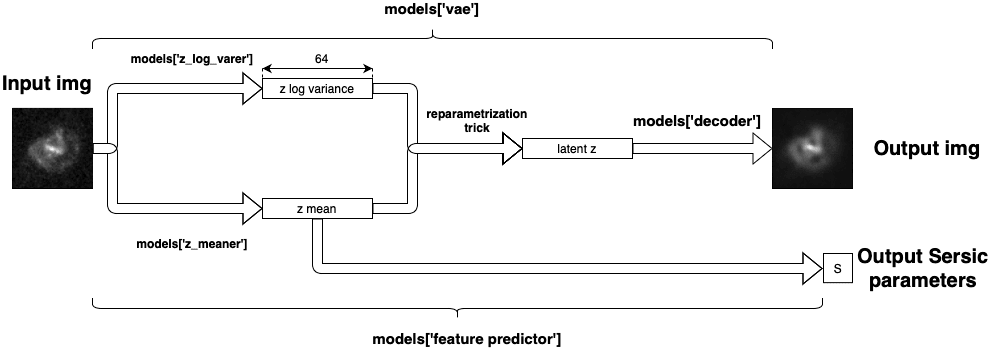

Decorators meant to create loss functions with given hyperparameters

In [29]:
def get_reconstruction_loss(loss_type='chi_sq'):

  if loss_type=='chi_sq':
    def reconstruction_loss_function(y_true,y_pred,labels):
      #Set the true values for Chi squared
      Amplitude_true=labels[:,0]
      Gaussian_noise=labels[:,1]
      #Cast images to original amplitude hence exposure
      y_max=get_matrix_shape(Amplitude_true,y_true)
      y_true = tf.convert_to_tensor(y_true)
      y_pred = tf.convert_to_tensor(y_pred)

      #(data-model)^2
      reconstruction_loss=K.square(y_true-y_pred)

      #Calculate Poisson and Gaussian noise
      #Originally error=sqrt(x/2028+gaussian^2)
      #If we normalize x'=x/amplitude we should normalize gaussian'=gaussian/amplitude too 
      Poisson_noise_variance=tf.abs(y_true/2028)
      Gaussian_noise_scaled=get_matrix_shape(Gaussian_noise/Amplitude_true,y_true)
      Gaussian_noise_variance=tf.math.pow(Gaussian_noise_scaled,2)

      #Calculate chi_sq weights=1/noise
      noise_variance=Poisson_noise_variance+Gaussian_noise_variance
      weights=tf.math.pow(noise_variance,-1)
      #Multiply by gaussian variance to return it to MSE scales
      weights= math_ops.cast(weights, y_pred.dtype)

      #chi_sq=(data-model)^2*weights
      chi_sq=reconstruction_loss*weights
      return K.sum(chi_sq,axis=-1)


  elif loss_type=='mse':
    def reconstruction_loss_function(y_true,y_pred,labels):
      #Set the true values for Chi squared
      Amplitude_true=labels[:,0]
      Gaussian_noise=labels[:,1]
      #Cast images to original amplitude hence exposure
      y_true = tf.convert_to_tensor(y_true)
      y_pred = tf.convert_to_tensor(y_pred)

      #(data-model)^2
      reconstruction_loss=K.square(y_true-y_pred)

      return 3*K.sum(reconstruction_loss,axis=-1)
  
  elif loss_type=='mae':
    def reconstruction_loss_function(y_true,y_pred,labels):
      #Set the true values for Chi squared
      Amplitude_true=labels[:,0]
      Gaussian_noise=labels[:,1]
      #Cast images to original amplitude hence exposure
      y_true = tf.convert_to_tensor(y_true)
      y_pred = tf.convert_to_tensor(y_pred)

      #(data-model)^2
      reconstruction_loss=K.abs(y_true-y_pred)

      return K.sum(reconstruction_loss,axis=-1)

  elif loss_type=='binary_crossentropy':
    def reconstruction_loss_function(y_true,y_pred,labels):
      return K.sum(K.binary_crossentropy(y_true,y_pred),axis=-1)
  else:
    print('Wrong loss type')
  
  return reconstruction_loss_function

def get_regularization_loss(gamma=None):

  #Capacity is a global variable that is changed during training
  def regularization_loss_function(mean,logvar):
    #global Capacity
    #global beta_vae
    KL_loss=0.5 * K.sum(K.exp(logvar)+K.square(mean)-1-logvar, axis=-1)
    if (gamma is not None) and (Capacity is not None):  
      return gamma*tf.abs(KL_loss-Capacity)
    else:
      return beta_vae*KL_loss
  
  return regularization_loss_function

In [30]:
def get_model_loss(loss_type='chi_sq',gamma=None):

  reconstruction_loss_function=get_reconstruction_loss(loss_type)
  regularization_loss_function=get_regularization_loss(gamma)

  def model_loss_function(target_x_labeled,x_decoded):
    #Target image
    x_true=target_x_labeled[:,:-1,:,:]
    #Target Sersic parameters
    labels=target_x_labeled[:,-1,:,0]
    #KL divergence regularization quality
    mean = models['z_meaner'](x_true)
    logvar=models['z_log_varer'](x_true)
    regularization_loss=regularization_loss_function(mean,logvar)
    
    #reconstruction quality
    reconstruction_loss=reconstruction_loss_function(x_true,x_decoded,labels)
    reconstruction_loss=K.sum(reconstruction_loss,axis=[1,2])


    Beta_VAE_Loss=(reconstruction_loss+regularization_loss)/image_size/image_size
    return Beta_VAE_Loss

  return model_loss_function,reconstruction_loss_function,regularization_loss_function

#### vae class

In [22]:
def create_vae(activation='softplus',loss_type='chi_sq',gamma=None):

    #Reparametrization trick
    def reparameterize(args):
      mean,logvar=args
      eps = tf.random.normal(shape=mean.shape)
      return eps * tf.exp(logvar/2) + mean
    decoder_function=get_decoder(activation)
    model_loss_function,reconstruction_loss_function,regularization_loss_function=get_model_loss(loss_type,gamma)


    #VAE
    models = {}

    #Encoder
    input_img = Input(batch_shape=(batch_size, image_size, image_size, 1))

    z_mean, z_log_var=encoder_function(input_img)

    l=Lambda(reparameterize, output_shape=(latent_dim,))([z_mean, z_log_var])

    models["encoder"]  = Model(input_img, l, name='Encoder') 
    models["z_meaner"] = Model(input_img, z_mean, name='Enc_z_mean')
    models["z_log_varer"] = Model(input_img, z_log_var, name='Enc_z_log_var')

    #Decoder
    z = Input(shape=(latent_dim, ))
    decoded=decoder_function(z)

    models["decoder"] = Model(z, decoded, name='Decoder')
    models["vae"]     = Model(input_img, models["decoder"](models["encoder"](input_img)), name="VAE")

    return models,model_loss_function,reconstruction_loss_function,regularization_loss_function

In [23]:
def get_Neural_Network(activation='softplus',loss_type='chi_sq',gamma=None):
  with tf.device('/device:GPU:0'):
    models,model_loss_function,reconstruction_loss_function,regularization_loss_function =create_vae(activation,loss_type,gamma)

    models["vae"].compile(optimizer=Adam(learning_rate=start_lr, beta_1=0.5, beta_2=0.999,clipvalue=1), loss=model_loss_function)

    return models,model_loss_function,reconstruction_loss_function,regularization_loss_function

### Load model

In [31]:
beta_start=1e-2
beta_vae=beta_start
beta_speed=0
gamma=None
Start_Capacity=0
Capacity_speed=0
activation='softplus'
loss_type='mse'

In [34]:
Checkpoint_to_load=0
Checkpoint_name='Models/Final training/MAE_beta=1e-2_pretrain_130ep_3*MSE/'
Checkpoints_Folder=Folder+Checkpoint_name

Capacity=Start_Capacity+(Checkpoint_to_load)*Capacity_speed
beta_vae=beta_start+(Checkpoint_to_load)*beta_speed


models,model_loss_function,reconstruction_loss_function,regularization_loss_function=get_Neural_Network(activation,loss_type,gamma)

Checkpoint_to_load_start=130
Checkpoints_Folder_start=Folder+'Models/Final training/MAE_beta=1e-2/'
models['vae'].load_weights(Checkpoints_Folder_start+'epoch_{}/Model'.format(Checkpoint_to_load_start))

if Checkpoint_to_load==0:
  try:
    os.mkdir(Checkpoints_Folder)
  except OSError as error:
    print(error)

#models['vae'].load_weights(Checkpoints_Folder+'epoch_{}/Model'.format(Checkpoint_to_load))

[Errno 17] File exists: '/content/drive/My Drive/Lensed Source modelling research/Models/Final training/MAE_beta=1e-2_pretrain_130ep_3*MSE/'


### Callbacks

In [35]:
from IPython.display import clear_output
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard
import seaborn as sns
import ast

# Отслеживать будем на вот этих цифрах
COSMOS_indices_to_compare=np.zeros(8,dtype=int)
COSMOS_indices_to_compare=[33671, 25576, 45805, 31577, 41707, 19844, 13628,  8624]
images_to_compare_indices=df[np.isin(df.COSMOS_index,COSMOS_indices_to_compare)].index
imgs=np.zeros((32,64,64,1))
imgs[:8] = gal_dataset_images[images_to_compare_indices]
labels_to_compare=np.ones((32,2))
labels_to_compare[:8]=df.iloc[images_to_compare_indices][['max_I','Noise_sigma']]
n_compare = 8

def plot_galaxies(*args,dimensions='2d',colorbar=False):
    #(num_of_rows,num_of_cols,im_shape[0],im_shape[1])
    args = [x.squeeze() for x in args]
    #num of cols
    n = min([x.shape[0] for x in args])
    I_max=np.max(args)
    print('Maximal brightness',I_max)

    if dimensions=='2d':
      fig=plt.figure(figsize=(2*n, 2*len(args)))
    else:
      fig=plt.figure(figsize=(5*n, 5*len(args)))

    for row in range(len(args)):
        for col in range(n):
            if dimensions=='2d':
                ax = fig.add_subplot(len(args),n,row*n+col+1)
                im=ax.imshow(args[row][col].squeeze(),cmap='Greys_r',vmax=I_max)
            else:
                ax = fig.add_subplot(len(args),n,row*n+col+1, projection='3d')
                ax.plot_surface(X, Y, args[row][col].squeeze(), cmap=cm.coolwarm,
                            linewidth=0, antialiased=False)
                ax.set_zlim(0,I_max)
            ax.set_xticks([])
            ax.set_yticks([])
    plt.subplots_adjust(wspace=0,hspace=0)
    plt.show()


def DKL_per_variable(z_means,z_log_vars):
    DKL=-0.5 * K.mean(1 + z_log_vars - K.square(z_means) - K.exp(z_log_vars), axis=0)
    sns.barplot(x=np.linspace(0,64,64),y=np.sort(DKL)[::-1])
    plt.xticks([])
    plt.xlabel('Latent variable')
    plt.ylabel('nats')
    plt.title(r'KL_div')
    plt.show()
    return K.eval(DKL)

def DKL_learning_curve(filename,start_epoch=0,stop_epoch=1000):
  text_file = open(filename, "r")
  lines = text_file.read().replace('\n','').replace('[','').split(']')
  nums=np.array([np.array([float(x) for x in line.split()]) for line in lines[:-1]])
  text_file.close()

  start_index=start_epoch//10
  stop_index=np.minimum(len(nums),stop_epoch//10-1)
  print(start_index,stop_index,len(nums))

  significant_vars=nums[-1].argsort()[-5:][::-1]
  for i in range(5):
    plt.plot(np.arange(start_index,stop_index),nums[start_index:stop_index,significant_vars[i]],label=i)
  plt.ylabel('nats')
  plt.xlabel('Checkpoint number')
  plt.title('DKL significant features Learning curve')
  plt.legend()
  plt.show()

  plt.plot(np.arange(start_index,stop_index),nums[start_index:stop_index].sum(axis=1))
  plt.ylabel('nats')
  plt.xlabel('Checkpoint number')
  plt.title('DKL Capacity Learning curve')
  plt.show()

def Show_latent_distr(models,x_test,reconst_loss_func=tf.keras.losses.binary_crossentropy,regul_loss_func=None):
  fig,ax=plt.subplots(2,2,figsize=(20,5))

  z_mean=K.eval(models['z_meaner'](x_test))
  z_log_var=K.eval(models['z_log_varer'](x_test))
  ratio=np.std(z_mean,axis=0)/np.mean(np.exp(z_log_var/2),axis=0)
  #Latent space SNR
  sns.barplot(ax=ax[0,0],x=np.linspace(0,64,64),y=np.sort(ratio)[::-1])
  ax[0,0].hlines(1,0,63,label=r'$\mu_{std}=\sigma_{mean}$')
  ax[0,0].legend()
  ax[0,0].set_xticks([])
  ax[0,0].set_xlabel('Latent variable')
  ax[0,0].set_ylabel('Ratio')
  ax[0,0].set_title('Latent SNR')

  #Latent space DKL
  DKL=0.5 * K.mean(K.exp(z_log_var)+K.square(z_mean) - 1 - z_log_var, axis=0)
  sns.barplot(ax=ax[0,1],x=np.linspace(0,64,64),y=np.sort(DKL)[::-1])
  ax[0,1].set_xticks([])
  ax[0,1].set_xlabel('Latent variable')
  ax[0,1].set_ylabel('nats')
  ax[0,1].set_title(r'KL_div')

  #reconstruction quality
  decoded=models['vae'].predict(x_test)
  labels=x_test_labeled[:,-1,:,0]
  Log_loss=K.mean(reconst_loss_func(x_test,decoded,labels),axis=[1,2])

  df=pd.DataFrame()
  df['Reconstruction loss']=Log_loss
  sns.barplot(ax=ax[1,0],data=df[['Reconstruction loss']])
  if regul_loss_func is not None:
    df['Regularization loss']=regul_loss_func(z_mean,z_log_var)/image_size/image_size
    sns.barplot(ax=ax[1,1],data=df[['Regularization loss']])

  plt.tight_layout()
  plt.show()

def learning_curve(filename,start_epoch=0,stop_epoch=1000):
  logs_file=open(filename)
  lines=logs_file.readlines()
  logs_file.close()


  loss=np.array([])
  val_loss=np.array([])
  for line in lines:
    note=ast.literal_eval(line)
    loss=np.append(loss,[note['loss']])
    val_loss=np.append(val_loss,[note['val_loss']])

  start_index=start_epoch//10
  stop_index=np.minimum(len(loss),stop_epoch//10+1)
  plt.plot(10*np.arange(start_index,stop_index),loss[start_index:stop_index],label='Train')
  plt.plot(10*np.arange(start_index,stop_index),val_loss[start_index:stop_index],label='Validation')
  plt.yscale('log')
  plt.ylabel('Loss')
  plt.xlabel('epoch number')
  plt.title('Learning curve')
  plt.legend()
  plt.show()


def calculate_gradient(image_true,image_pred,labels,reconstruction_loss_function):
    image_true=tf.constant(image_true)
    image_pred=tf.constant(image_pred)
    labels=tf.constant(labels)
    with tf.GradientTape(watch_accessed_variables=False, persistent=True) as g:
      g.watch(image_pred)
      loss=reconstruction_loss_function(image_true,image_pred,labels)
    return K.eval(g.gradient(loss,image_pred))

def present_reconstruction(models,imgs,reconstruction_loss_function=None,labels=None,dimensions='2d',resid=False, grads=False,abs_grads=True):
    #Images selection
    images_for_reconst=imgs
    decoded_to_reconstruct=models['vae'].predict(images_for_reconst, batch_size=len(imgs))
    plot_galaxies(images_for_reconst[:8],decoded_to_reconstruct[:8],dimensions=dimensions)
    if grads:
        if (reconstruction_loss_function is not None) and (labels is not None):
          gradients=calculate_gradient(images_for_reconst,decoded_to_reconstruct.astype('double'),labels.astype('double'),reconstruction_loss_function)
          if abs_grads:
            norm_gradients=np.abs(gradients)
            norm_gradients=np.array([norm_gradients[i]/norm_gradients[i].flatten().max() for i in range(len(norm_gradients))])
            plot_galaxies(norm_gradients[:8],dimensions=dimensions,colorbar=True)
          else:
            norm_gradients=np.array([gradients[i]-gradients[i].flatten().min() for i in range(len(gradients))])
            norm_gradients=np.array([norm_gradients[i]/norm_gradients[i].flatten().max() for i in range(len(norm_gradients))])
            plot_galaxies(norm_gradients[:8],dimensions=dimensions,colorbar=True)
    if resid:
      if (reconstruction_loss_function is None) or (labels is None):
          residuals=decoded_to_reconstruct-images_for_reconst
      else:
          residuals=K.eval(reconstruction_loss_function(images_for_reconst,decoded_to_reconstruct.astype('double'),labels.astype('double')))
      plot_galaxies(residuals[:8],dimensions=dimensions,colorbar=True)
    if grads:
      return gradients
    elif resid:
      return residuals
def on_epoch_end(epoch=0, logs=''):
  global beta_vae
  Epoch_Capacity=Start_Capacity+(epoch+Checkpoint_to_load)*Capacity_speed
  #Every 10 epoch do the following
  if np.mod(epoch,1)==0:
        clear_output()
        
        imgs_decoded=models['vae'].predict(imgs, batch_size=batch_size)
        _=present_reconstruction(models,imgs,reconstruction_loss_function,labels_to_compare,grads=True,abs_grads=True)
        
        labels=x_test_labeled[:,-1,:,0]
        decoded = models['vae'].predict(x_test, batch_size=batch_size)

        gradients=calculate_gradient(x_test,decoded,labels,reconstruction_loss_function)
        Max_gradients=np.max(gradients.reshape((len(gradients),4096)),axis=1)
        plt.hist(Max_gradients,bins=20)
        plt.title('Max gradients')
        plt.show()

        #Also take a look on how latent space variables are distributed
        Show_latent_distr(models,x_test,reconstruction_loss_function,regularization_loss_function)

        mean = models['z_meaner'](x_test)
        logvar=models['z_log_varer'](x_test)
        DKL=DKL_per_variable(mean,logvar)
        #print('Controlled Capacity',Epoch_Capacity)
        print('Latent space Capacity',DKL.sum())
        #print('Beta', beta_vae)

        fig,ax=plt.subplots(1,3,figsize=(10,5))
        maxima=K.eval(decoded).max(axis=(1,2,3))
        maxima_RAE=np.abs(maxima-1)
        ax[0].hist(maxima,bins=20)
        ax[0].set_title('Distribution of reconstructed maximum')

        reconstruction_loss=K.eval(K.mean(reconstruction_loss_function(x_test,decoded,labels),axis=[1,2]))
        reconstruction_loss=np.sort(reconstruction_loss)[:int(len(reconstruction_loss)*0.99)]
        ax[1].hist(reconstruction_loss,bins=40)
        ax[1].set_title('reconstruction loss')

        SSIM=tf.image.ssim(x_test.astype('double'), decoded.astype('double'),max_val=1,filter_size=8).numpy()
        ax[2].hist(SSIM,bins=20)
        ax[2].set_title('SSIM')
        plt.show()

        print('Max values RAE {:.3f} ± {:.3f}, median {:.3f}'.format(maxima_RAE.mean(),maxima_RAE.std(),np.median(maxima_RAE)))
        print('reconstruction loss values {:.3f} ± {:.3f}, median {:.3f}'.format(reconstruction_loss.mean(),reconstruction_loss.std(),np.median(reconstruction_loss)))
        print('SSIM values {:.3f} ± {:.3f}, median {:.3f}'.format(SSIM.mean(),SSIM.std(),np.median(SSIM)))
        
        if (epoch!=0):
          #Write loss logs
          file_object = open(Checkpoints_Folder+'logs.txt', 'a')
          file_object.write(str(logs))
          file_object.write('\n')
          file_object.close()

          #Write KL divergence of latent space 
          file_object = open(Checkpoints_Folder+'DKL.txt', 'a')
          file_object.write(str(DKL))
          file_object.write('\n')
          file_object.close()

          learning_curve(Checkpoints_Folder+'logs.txt',0,100000)

          DKL_learning_curve(Checkpoints_Folder+'DKL.txt')
          #Make a checkpoint of model weights and logs on Google drive
          if np.mod(epoch,10)==0:
            Model_folder=Checkpoints_Folder+'epoch_{}/Model'.format(Checkpoint_to_load+epoch)
            models['vae'].save_weights(Model_folder)



def on_epoch_begin(epoch=0, logs=''):
  global Capacity
  global beta_vae
  Epoch_Capacity=Start_Capacity+(epoch+Checkpoint_to_load)*Capacity_speed
  Epoch_beta=beta_start+(epoch+Checkpoint_to_load)*beta_speed
  #Assign new value to the global variable Capacity
  Capacity=Epoch_Capacity
  beta_vae=Epoch_beta

        

        
# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)
capacity_control=LambdaCallback(on_epoch_begin=on_epoch_begin)
lr_red = ReduceLROnPlateau(factor=0.1, patience=10, min_lr=1e-10,verbose=1)

### Training

Maximal brightness 1.0


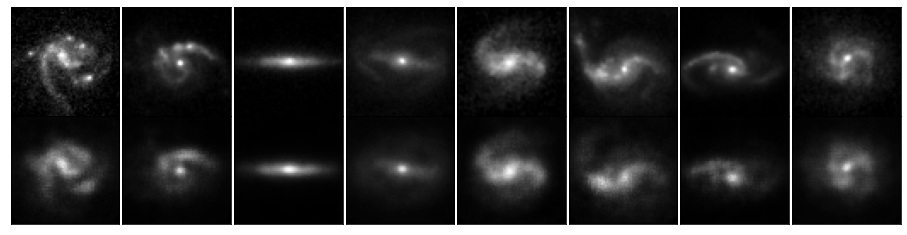

Maximal brightness 1.0


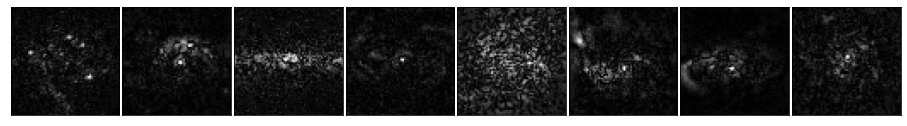

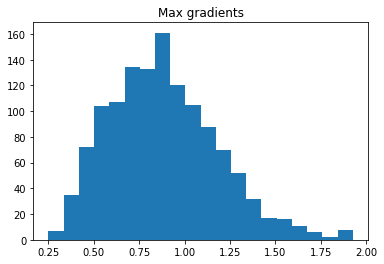

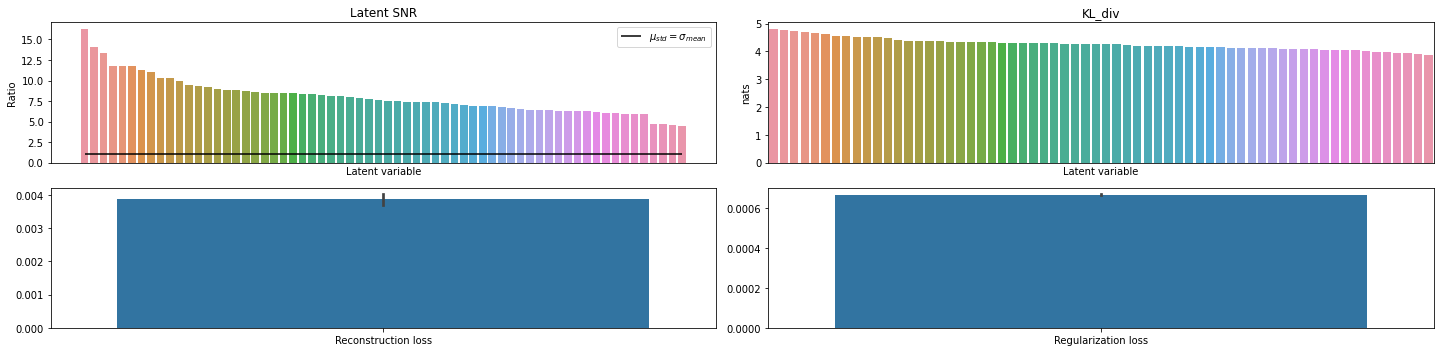

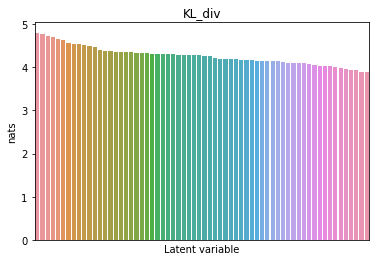

Latent space Capacity 273.1375


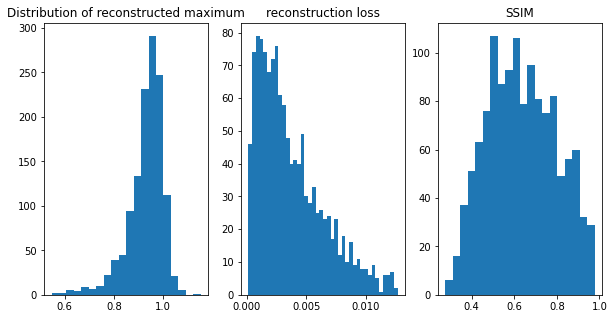

Max values RAE 0.073 ± 0.068, median 0.055
reconstruction loss values 0.004 ± 0.003, median 0.003
SSIM values 0.637 ± 0.160, median 0.626


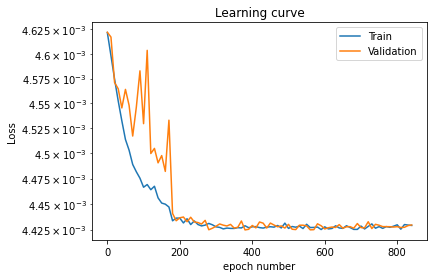

0 85 85


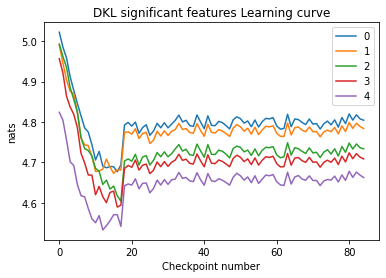

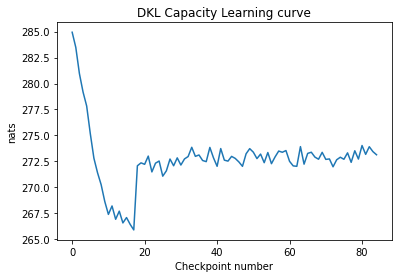

Epoch 87/900
196/716 [=======>......................] - ETA: 1:41 - loss: 0.0044

In [ ]:
_ = models['vae'].fit(x_train,x_train_labeled, shuffle=True, epochs=900,
        batch_size=batch_size,
        validation_data=(x_val,x_val_labeled),
        callbacks=[pltfig,lr_red],
        verbose=1)